# Function Definitions

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from sklearn.preprocessing import normalize
from functools import partial

%matplotlib inline

#target = -1 + 2*x1 + 2*x2 #np.array([2,2,-1])
df = pd.DataFrame({
    'x1': [0, 1, 0, -0.5, -1, 2, 1, 3, 0.5, -1, 0, -2, -3, 1, 2, -4, -3, 3, -0.5, -2],
    'x2': [0, 1, 1, 0, -1, 4, -1, -5, -2, 1, 3, 0, -1, 6, 8, 2, 3, 10, 2, 1],
    'y': [1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
})

df['x0'] = 1
df = df[['x0', 'x1', 'x2', 'y']]


def perceptron(points, dim, max_it=100, use_adaline=False,
               eta=1, randomize=False, print_out=True):
    w = np.zeros(dim + 1)
    xs, ys = points[:, :dim + 1], points[:, dim + 1]
    num_points = points.shape[0]
    for it in range(max_it):
        correctly_predicted_ids = set()
        idxs = np.arange(num_points)
        if randomize:
            idxs = np.random.choice(np.arange(num_points), num_points, replace=False)
        for idx in idxs:
            x, y = xs[idx], ys[idx]
            st = np.dot(w.T, x)
            prod = st * y  #np.dot(w.T, x)*y
            if prod < -100:  #avoid out of bound error
                st = -100
            threshold = 1 if use_adaline else 0
            st = st if use_adaline else 0
            if prod <= threshold:
                w = w + eta * (y - st) * x
                break  #PLA picks one example at each iteration
            else:
                correctly_predicted_ids.add(idx)
        if len(correctly_predicted_ids) == num_points:
            break

    c = 0
    for x, y in zip(xs, ys):
        prod = np.dot(w.T, x) * y
        if prod > 0:
            c += 1
    w = w / w[-1]
    if print_out:
        print('final correctness: ', c, '. Total iteration: ', it)
        print('final normalized w:', w)
    return w, it


def flip_coins(total_coins):
    """Flip all coins once, return their head/tail status
    """

    hts = np.zeros(total_coins)  #head: 1, tail: 0
    probs = np.random.uniform(size=total_coins)
    hts[probs > 0.5] = 1
    return hts


def run_once(total_coins, total_flips, print_freq=False):
    v1, vrand, vmin = None, None, None
    crand = np.random.choice(total_coins)
    hts_sum = np.zeros(total_coins)  # store the sum of heads in total_flips

    for flip in range(total_flips):
        hts_sum = hts_sum + flip_coins(total_coins)

    hts_freq = hts_sum / total_flips

    v1 = hts_freq[0]
    vrand = hts_freq[crand]
    cmin = np.argmin(hts_sum)
    vmin = hts_freq[cmin]

    if print_freq:
        print('Frequency of first coin: {}'.format(v1))
        print('Frequency of a random coin: id({})-freq({})'.format(crand, vrand))
        print('Frequency of the coin with minimum frequency: id({})-freq({})'.format(cmin, vmin))
    return v1, vrand, vmin


def hoeffding_bound(epsilon, n):
    return 2.0 * np.exp(-2.0 * n * epsilon ** 2)


def generate_random_numbers01(N, dim, num_grid_points):
    random_ints = np.random.randint(num_grid_points, size=(N, dim))
    init_lb = 0
    return (random_ints - init_lb) / (num_grid_points - 1 - init_lb)


def generate_random_numbers(N, dim, num_grid_points, lb, ub):
    zero_to_one_points = generate_random_numbers01(N, dim, num_grid_points)
    res = lb + (ub - lb) * zero_to_one_points
    return res


def generate_random_coeffs(dim):
    rn = generate_random_numbers(1, dim, 1000, -10, 10)
    return rn


def true_f(x, coeffs):
    return coeffs.flatten()[0] + np.dot(coeffs.flatten()[1:], x.flatten())


def generate_two_classes(N, dim, true_func, rn_func):
    cls1, cls2 = [], []
    while True:
        rn = rn_func(1, dim).flatten()
        if true_func(rn) > 0 and len(cls1) < N:
            cls1.append(rn)
        elif true_func(rn) < 0 and len(cls2) < N:
            cls2.append(rn)
        if len(cls1) == N and len(cls2) == N:
            break
    return np.asarray(cls1), np.asarray(cls2)


def generate_df(N, dim, true_func, rn_func):
    cls1, cls2 = generate_two_classes(N / 2, dim, true_func, rn_func)
    cols = ['x' + str(i) for i in range(1, dim + 1)]
    df1 = pd.DataFrame(cls1, columns=cols)
    df1['y'] = 1
    df2 = pd.DataFrame(cls2, columns=cols)
    df2['y'] = -1
    df = pd.concat([df1, df2])
    df['x0'] = 1
    df = df[['x0'] + cols + ['y']]
    return df


def plot_data(x1, df, norm_coeffs, norm_g, lb, ub):
    figsize = plt.figaspect(1)
    f, ax = plt.subplots(1, 1, figsize=figsize)
    cls1_df = df.loc[df['y'] == 1]
    cls2_df = df.loc[df['y'] == -1]
    line = ax.plot(x1, -(norm_coeffs[0] + norm_coeffs[1] * x1), label='True Function')
    pluses = ax.scatter(cls1_df[['x1']].values, cls1_df[['x2']].values, marker='+', c='r', label='+1 labels')
    minuses = ax.scatter(cls2_df[['x1']].values, cls2_df[['x2']].values, marker=r'$-$', c='b', label='-1 labels')
    if norm_g is not None:
        hypothesis = ax.plot(x1, -(norm_g[0] + norm_g[1] * x1), c='r', label='Final Hypothesis')

    ax.set_ylabel(r"$x_2$", fontsize=11)
    ax.set_xlabel(r"$x_1$", fontsize=11)
    ax.set_title('Data set size = %s' % N, fontsize=9)
    ax.axis('tight')
    legend_x = 2.0
    legend_y = 0.5
    ax.legend(['True Function', '+1 labels',
               '-1 labels', 'Final Hypothesis', ],
              loc='center right', bbox_to_anchor=(legend_x, legend_y))
    #ax.legend(handles=[pluses, minuses], fontsize=9)
    ax.set_ylim(bottom=lb, top=ub)
    plt.show()


def run_perceptron_experiment(N, dim, lb, ub, num_grid_points, coeff_lb, coeff_ub,
                              eta, maxit, use_adaline=False, randomize=False,
                              show_plot=True, test_N=10000):
    rns = generate_random_numbers(N, dim, num_grid_points, lb, ub)
    rn_func = partial(generate_random_numbers, num_grid_points=num_grid_points, lb=lb, ub=ub)
    coeffs = generate_random_numbers(1, dim + 1, num_grid_points, coeff_lb, coeff_ub)
    norm_coeffs = coeffs.flatten() / coeffs.flatten()[-1]
    true_func = partial(true_f, coeffs=norm_coeffs)

    df = generate_df(N, dim, true_func, rn_func)
    test_df = generate_df(test_N, dim, true_func, rn_func)

    x1 = np.arange(lb, ub, 0.01)
    norm_g, num_its = perceptron(df.values, dim, maxit, use_adaline,
                                 eta, randomize, show_plot)

    if show_plot:
        print('True coeffs: ', norm_coeffs)
        plot_data(x1, df, norm_coeffs, norm_g, lb, ub)
    return num_its, norm_g, test_df

## Exercises

#### Exercise 1.1
Express each of the following tasks in the framework of learning from data by specifying the input space $X$, output space $Y$, target function $f$: $X$ -> $Y$, and the specifics of the data set that we will learn from.
1. (a)  Medical diagnosis: A patient walks in with a medical history and some symptoms, and you want to identify the problem.
  * Input space $\mathcal{X}$: patient's medical history, symptoms, personal health information etc.
  * Output space $\mathcal{Y}$: all possible diseases
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal formula to identify a patient's problem
  * Data set: All available patients' information and their corresponding correct problem diagnostic.
2. (b) Handwritten digit recognition (for example postal zip code recognition for mail sorting).
  * Input space $\mathcal{X}$: handwritten digits (digitalized)
  * Output space $\mathcal{Y}$: 0-9 digits
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal formula match a handwritten digit to a correct digit
  * Data set: handwritten digits and their corresponding correct matches
3. (c) Determining if an email is spam or not.
  * Input space $\mathcal{X}$: every information of an email, e.g. words
  * Output space $\mathcal{Y}$: yes/no
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal formula to identify whether an email is spam or not
  * Data set: Spam and non-spam emails that have been identified by human
4. (d) Predicting how an electric load varies with price, temperature, and day of the week.
  * Input space $\mathcal{X}$: price of electric, temperature, day of the week
  * Output space $\mathcal{Y}$: electric load
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal function that gives exact electric load for a given price, temperature and day of the week.
  * Data set: historical electric load along with corresponding price, temperature and day of the week information.
5. (e) A problem of interest to you for which there is no analytic solution, but you have data from which to construct an empirical solution.
  * Input space $\mathcal{X}$: dog images
  * Output space $\mathcal{Y}$: types of dogs
  * target function $f: \mathcal{X} \to \mathcal{Y}$: ideal function that gives dog type according to the picture
  * Data set: picutres with dogs that have been categorized to various types

#### Exercise 1.2
Suppose that we use a perceptron to detect spam messages. Let's say that each email message is represented by the frequency of occurrence of keywords, and the output is if the message is considered spam.

(a) Can you think of some keywords that will end up with a large positive weight in the perceptron?

(b) How about keywords that will get a negative weight?

(c) What parameter in the perceptron directly affects how many borderline messages end up being classified as spam?

1. (a) Keywords with a large positive weight: free, cheap, earn

1. (b) Keywords with a negative weight: person name, hi, the

1. (c) The parameter $b$ in perceptron directly affects how many borderline messages end up being classified as spam. This is because $b$ is the threshold used to classify the emails into spam and non-spam categories.

#### Exercise 1.3
The weight update rule ($w(t+1)= w(t)+y(t)x(t)$) has the nice interpretation that it moves in the direction of classifying $x(t)$ correctly.

(a) Show that $y(t)w^T(t)x(t) < 0$. [Hint: $x(t)$ is misclassified by $w(t)$.]

(b) Show that $y(t)w^T(t+l)x(t) > y(t)w^T(t)x(t)$. [Hint: Use $w(t+1)= w(t)+y(t)x(t).$]

(c) As far as classifying $x(t)$ is concerned, argue that the move from $w(t)$ to $w(t+1)$ is a move 'in the right direction'.


1. (a) If $x(t)$ is misclassified by $w(t)$, then $w^T(t)x(t)$ has different signs of $y(t)$, thus $y(t)w^T(t)x(t) \lt 0$.

1. (b) \begin{align*}
y(t)w^T(t+1)x(t) &= y(t) \left(w(t)+y(t)x(t)\right)^Tx(t) \\
&= y(t)\left(w^T(t) + y(t)x^T(t)\right)x(t) \\
&= y(t)w^T(t)x(t) + y(t)y(t)x^T(t)x(t)\\
&\gt y(t)w^T(t)x(t) \;\;\;\text{because the last term is } \ge \text{ than } 0\\
\end{align*}

1. (c) From previous problem, we see that $y(t)w^T(t)x(t)$ is increasing with each update.

If $y(t)$ is positive, but $w^T(t)x(t)$ is negative, we move $w^T(t)x(t)$ toward positive by increasing it.

If however $y(t)$ is negative, but $w^T(t)x(t)$ is positive, $y(t)w^T(t)x(t)$ increases means $w^T(t)x(t)$ is decreasing, i.e. moving toward negative region.

So the move from $w(t)$ to $w(t+1)$ is a move "in the right direction" as far as classifying $x(t)$ is concerned.

#### Exercise 1.4
Let us create our own target function $f$ and data set $D$ and see how the perceptron learning algorithm works. Take $d$ = 2 so you can visualize the problem, and choose a random line in the plane as your target function, where one side of the line maps to 1 and the other maps to -1. Choose the inputs $x_{n}$ of the data set as random points in the plane, and evaluate the target function on each $x_{n}$ to get the corresponding output $y_{n}$.

Now, generate a data set of size 20. Try the perceptron learning algorithm on your data set and see how long it takes to converge and how well the final hypothesis $g$ matches your target $f$.


Implement the perceptron learning algorithm and check:
* Convergence speed: The convergence is fast, it depends on the data, but usually it only takes about 10 iterations to find a solution.
* How well the final hypothesis $g$ matches your target $f$: The final hypothesis $g$ doesn't match my target $f$ very closely in terms of their coefficients. But from picture, they are largely in line with each other in the range of data.

final correctness:  20 . Total iteration:  3
final normalized w: [0.0366789  0.58654434 1.        ]
True coeffs:  [-0.19837233  0.44659207  1.        ]


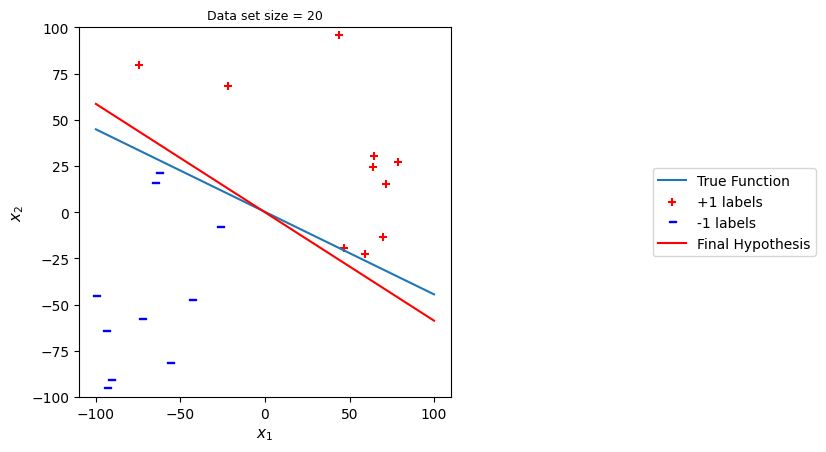

In [ ]:
#perceptron(df.values, 2)

lb, ub = -100, 100
N, dim = 20, 2
num_grid_points = 2000
coeff_lb, coeff_ub = -10, 10
eta = 1.0
maxit = 100
use_adaline, randomize = False, False
_, _, _ = run_perceptron_experiment(N, dim, lb, ub, num_grid_points, coeff_lb, coeff_ub, eta, maxit, use_adaline, randomize)

#### Exercise 1.5
Which of the following problems are more suited for the learning approach and which are more suited for the design approach?

The main difference between the learning approach and the design approach is the role that data plays.

In the design approach, the problem is well specified and one can analytically derive $f$ without the need to see any data.

In the learning approach, the problem is much less specified, and one needs data to pin down what $f$ is.

(a) Determining the age at which a particular medical test should be performed

(b) Classifying numbers into primes and non-primes

(c) Detecting potential fraud in credit card charges

(d) Determining the time it would take a falling object to hit the ground

(e) Determining the optimal cycle for traffic lights in a busy intersection

1. (a) Learning
1. (b) Design
1. (c) Learning
1. (d) Design
1. (e) Learning

#### Exercise 1.6
For each of the following tasks, identify which type of learning is involved (supervised, reinforcement, or unsupervised) and the training data to be used. If a task can fit more than one type, explain how and describe the training data for each type.

(a) Recommending a book to a user in an online bookstore

(b) Playing tic tac toe

(c) Categorizing movies into different types

(d) Learning to play music

(e) Credit limit: Deciding the maximum allowed debt for each bank customer

1. (a) Supervised Learning
1. (b) Reinforcement Learning
1. (c) Unsupervised Learning
1. (d) Learning to play music
  * If learn by yourself, it's unsupervised learning
  * If learn from a teacher, it's supervised learning
  * If learn by yourself but with someone to tell you if your music is good or not, it's reinforcement learning.
1. (e) Supervised Learning

#### Exercise 1.7

<img src='https://drive.google.com/uc?id=1YT9yY7lUk7SPsjVgM60W8PGkOjCm9gip'>

For each of the following learning scenarios in the above problem, evaluate the performance of the final hypothesis $g$ on the three points in $X$ outside $D$. To measure the performance, compute how many of the 8 possible target functions agree with $g$ on all three points, on two of them, on one of them, and on none of them. How many distinct functions $f$ do we have?

(a) $H$ has only two hypotheses, one that always returns '•' and one that always returns 'o'. The learning algorithm picks the hypothesis that matches the data set the $most$.

(b) The same $H$, but the learning algorithm now picks the hypothesis that matches the data set the $least$.

(c) $H$ = {XOR} (only one hypothesis which is always picked), where XOR is defined by XOR(x) = '•' if the number of 1's in $x$ is odd and XOR(x) = 'o' if the number is even.

(d) $H$ contains all possible hypotheses (all Boolean functions on three variables), and the learning algorithm picks the hypothesis that agrees with all training examples, but otherwise disagrees the most with the XOR.


1. (a) The learning algorithm will pick the final hypothesis that always returns 1.
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
1. (b) The learning algorithm will pick the final hypothesis that always returns 0.
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
1. (c) The learning algorithm will pick the final hypothesis $XOR$.
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
1. (d) The learning algorithm will pick the final hypothesis $f_7$.
  * 1 out of 8 $f$ agrees with $g$ on all three points; 3 $f$ agree with $g$ on two of the points; 3 $f$ agree with $g$ on one of the points, 1 $f$ agrees with none of the points.
  
#### Exercise 1.8
If $μ$ = 0.9, what is the probability that a sample of 10 marbles will have $v$ <= 0.1? [Hints: 1. Use binomial distribution. 2. The answer is a very small number.]

In a sample of 10 marbles, for the fraction $\nu$ of red marbles to be $\nu \le 0.1$, we must have at most one red marbles.

\begin{align*}
P(number\;of\;red \le 1) &= P(red = 0) + P(red = 1) \\
&= (1-\mu)^{10} + \mu (1-\mu)^9\\
&= (1-\mu)^9\\
&= 1.0e-9
\end{align*}

#### Exercise 1.9
If $μ$ = 0.9, use the Hoeffding inequality to bound the probability that a sample of 10 marbles will have $v$ <= 0.1 and compare the answer to the previous exercise.

We have $\mu=0.9$, $N=10$, and want $\nu \le 0.1$, i.e. $|\mu - \nu| = \mu - \nu \ge 0.9 - 0.1 = 0.8$. Let's pick $\epsilon = 0.7$, then according to Hoeffding Inequity, we have

\begin{align*}
P(\nu \le 0.1) &= P(\mu - \nu \ge 0.8)\\
&= P(|\mu - \nu| \ge 0.8) \\
&\le P(|\mu - \nu| \gt 0.7) \\
&= P(|\mu - \nu| \gt \epsilon) \\
&\le 2e^{-2\epsilon^2N}\\
&\approx 0.0001109032
\end{align*}

This is an upper bound of the probability from previous problem and is much larger than the calculated probability.


#### Exercise 1.10
Here is an experiment that illustrates the difference between a single bin and multiple bins. Run a computer simulation for flipping 1,000 fair coins. Flip each coin independently 10 times. Let's focus on 3 coins as follows: $c_{1}$ is the first coin flipped; $c_{rand}$ is a coin you choose at random; $c_{min}$ is the coin that had the minimum frequency of heads (pick the earlier one in case of a tie). Let $v_{1}$, $v_{rand}$ and $v_{min}$ be the fraction of heads you obtain for the respective three coins.

(a) What is $μ$ for the three coins selected?

(b) Repeat this entire experiment a large number of times (e.g., 100,000 runs of the entire experiment) to get several instances of $v_{1}$, $v_{rand}$ and $v_{min}$ and plot the histograms of the distributions of $v_{1}$, $v_{rand}$ and $v_{min}$. Notice that which coins end up being $c_{rand}$ and $c_{min}$ may differ from one run to another.

(c) Using (b), plot estimates for P[|$v$-μ| > $\epsilon$] as a function of $\epsilon$, together with the Hoeffding bound $2e^{-2\epsilon^2N}$ (on the same graph).

(d) Which coins obey the Hoeffding bound, and which ones do not? Explain why.

(e) Relate part (d) to the multiple bins in Figure 1.10.

<img src='https://drive.google.com/uc?id=1jHql9EuaaevkVGPB6ZN6__RN5YHfhkb_'>


1. (a) The $\mu$ for the three coins are all $0.5$ since the coins are fair.

In [ ]:
# Exercise 1.10 (a)
total_coins = 1000
total_flips = 10
run_once(total_coins, total_flips, True)

(array([6.2324e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.7674e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

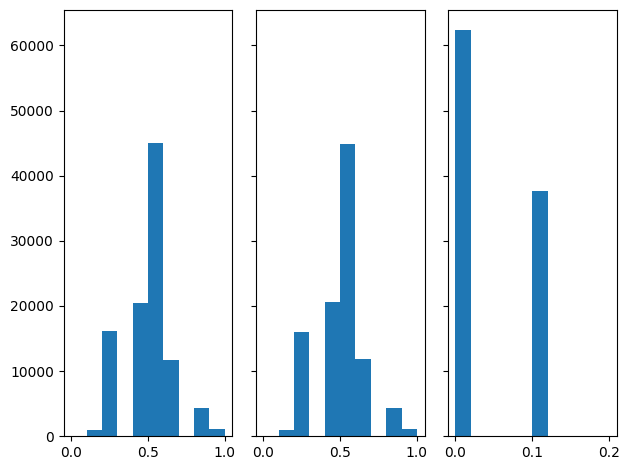

In [ ]:
# Exercise 1.10 (b)
total_coins = 1000
total_flips = 10
total_runs = 100000
v1s, vrands, vmins = [], [], []
for run in range(total_runs):
    v1, vrand, vmin = run_once(total_coins, total_flips)
    v1s.append(v1)
    vrands.append(vrand)
    vmins.append(vmin)

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
n_bins = 10
axs[0].hist(v1s, bins=n_bins)
axs[1].hist(vrands, bins=n_bins)
axs[2].hist(vmins, bins=n_bins)

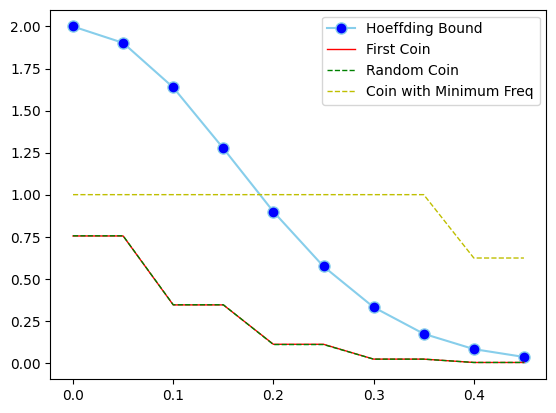

In [ ]:
# Exercise 1.10 (c)
eps = np.arange(0.0, 0.5, 0.05)
bounds = hoeffding_bound(eps, total_flips)
v1s, vrands, vmins = np.array(v1s), np.array(vrands), np.array(vmins)
v1d = np.abs(v1s - 0.5)
vrandd = np.abs(vrands - 0.5)
vmind = np.abs(vmins - 0.5)

p1, prand, pmin = np.zeros(len(eps)), np.zeros(len(eps)), np.zeros(len(eps))

for idx in range(eps.shape[0]):
    ep = eps[idx]
    p1[idx] = np.sum(v1d > ep) / total_runs
    prand[idx] = np.sum(vrandd > ep) / total_runs
    pmin[idx] = np.sum(vmind > ep) / total_runs

#plt.ylim((0,0.01))
plt.plot(eps, bounds, marker='o', markerfacecolor='blue', markersize=8, color='skyblue', label='Hoeffding Bound')
plt.plot(eps, p1, marker='', color='r', linewidth=1, label='First Coin')
plt.plot(eps, prand, marker='', color='g', linewidth=1, linestyle='dashed', label='Random Coin')
plt.plot(eps, pmin, marker='', color='y', linewidth=1, linestyle='dashed', label='Coin with Minimum Freq')
plt.legend()

#### Exercise 1.10
1. (d) The first and random coins follow the Hoeffding bound. The coin with minimum frequency doesn't obey Hoeffding bound. This is because that for the first two coins, the coins were chosen before the experiment. While for the last one, we have to flip all the coins first, and use the data to compute out which is the coin with minimum frequency of heads. This violates the Hoeffding inequality condition which says the hypothesis $h$ has been fixed before samples were drawn.

1. (e) When we choose the coin having the minimum frequency of heads it is like choosing the bin from 1000 bins (hypothesis space). We choose the bin after we finish sampling the data. This is akin to learning algorithm for the final hypothesis. The other two coins were chosen before the sampling, which is choosing bin beforehand.

#### Exercise 1.11
We are given a data set $D$ of 25 training examples from an unknown target function $f: X -> Y$, where $X$ = $R$ and $Y$ = {-1,+1}. To learn $f$, we use a simple hypothesis set $H$ = {$h1, h2$} where $h1$ is the constant +1 function and $h2$ is the constant -1.

We consider two learning algorithms, $S$ (smart) and $C$ (crazy). $S$ chooses the hypothesis that agrees the most with $D$ and $C$ chooses the other hypothesis deliberately. Let us see how these algorithms perform out of sample from the deterministic and probabilistic points of view. Assume in the probabilistic view that there is a probability distribution on $X$, and let P[$f(x) = +1$] = $p$.

(a) Can $S$ produce a hypothesis that is $guaranteed$ to perform better than random on any point outside $D$?

(b) Assume for the rest of the exercise that all the examples in $D$ have $y_{n}$ = +1. Is it possible that the hypothesis that $C$ produces turns out to be better than the hypothesis that $S$ produces?

(c) If $p$ = 0.9, what is the probability that $S$ will produce a better hypothesis than $C$?

(d) Is there any value of $p$ for which it is more likely than not that $C$ will produce a better hypothesis than $S$?

1. (a) $S$ can not produce a hypothesis that is guaranteed to perform better than random on any point outside $\mathcal{D}$.
If $f$ has 25 $+1$ on $\mathcal{D}$ but $-1$ on all other points in $\mathcal{X}$, $S$ will choose the hypothesis $h_1$, which will not match $f$ outside of $\mathcal{D}$ at all. On the other hand, a random function will have $+1$ and $-1$ 50/50, and it matches $f$ half of time, which is better than the function produced by $S$.

1. (b) It is possible that $C$ produces a better hypothesis than $S$ produces. See the example above.

1. (c) If every point in $\mathcal{D}$ has 1, then $S$ will choose $h_1$ and $C$ will choose $h_2$. So outside of $\mathcal{D}$, $h_1$ will have 90% chance to match with $f$, while $h_2$ will have only 10% chance. $S$ will always produce a better hypothesis than $C$.

1. (d) From previous problem, we can see that when $p \lt 0.5$, $C$ will produce a better hypothesis than $S$. Since $C$ always produces $h_2$, it will match $f$ better than $h_1$ if $p \lt 0.5$.

**Conclusion:** The question of whether $D$ tells us anything outside of $D$ that we didn't know before has two different answers.

If we adopt a deterministic perspective, which means that $D$ tells us something certain about $f$ outside of $D$, then the answer is no.

If we adopt a probabilistic pespective, which means that $D$ tells us something likely about $f$ outside of $D$, then the answer is yes. By adopting the probabilistic view, we get a positive answer to the feasibility question without paying too much of a price. The only assumption in the probabilistic framework is that the examples in $D$ are generated $independently$. Whatever distribution we use for generating the examples, we $must$ also use it when we evaluate how well $g$ approximates $f$. This makes the Hoeffding Inequality applicable.

#### Exercise 1.12

A friend comes to you with a learning problem. She says the target function $f$ is $completely$ unknown, but she has 4000 data points. She is willing to pay you to solve her problem and produce for her a $g$ which approximates $f$. What is the best that you can promise her among the following:

(a) After learning you will provide her with a $g$ that you will guarantee approximates $f$ well out of sample.

(b) After learning you will provide her with a $g$, and with high probability the $g$ which you produce will approximate $f$ well out of sample.

(c) One of two things will happen:

(i) You will produce a hypothesis $g$;

(ii) You will declare that you failed.

If you do return a hypothesis $g$, then with high probability the $g$ which you produce will approximate $f$ well out of sample.

Answer:

The best we can promise is (c).
* The unknown target $f$ can be very complex that we can't learn at all.
* If we can learn and produce a hypothesis $g$, since there are many data points (4000), the probability that $g$ matches $f$ is high according to Hoeffding inequality, and the error on $g$ might be small since we have a large data set.

**Conclusion:**
The feasibility of learning has two questions:

1. Can we make $E_{out}(g)$ close enough to $E_{in}(g)$?
2. Can we make $E_{in}(g)$ small enough?

HI addresses the first question only.
The second question is answered after we run the learning algorithm on the actual data and see how small we can get $E_{in}(g)$ to be.

#### Exercise 1.13
Consider the bin model for a hypothesis $h$ that makes an error with probability μ in approximating a deterministic target function $f$ (both $h$ and $f$ are binary functions). If we use the same $h$ to approximate a noisy version of $f$ given by

<img src='https://drive.google.com/uc?id=1JYqM1j3J2icslCdWtXWOANON7AOVJpL2'>

(a) What is the probability of error that $h$ makes in approximating $y$?

(b) At what value of $\lambda$ will the performance of $h$ be independent of μ? [Hint: The noisy target will look completely random.]

1. (a) The probability of error that $h$ makes in approximating $y$ is

\begin{align*}
P(h \ne y) &= P(h \ne y| y = f(x))P(y=f(x)) + P(h\ne y| y \ne f(x))P(y\ne f(x))\\
&= \mu \lambda + (1-\mu)(1-\lambda)\\
&= \mu (2 \lambda - 1) + (1-\lambda)\\
\end{align*}

1. (b) It can be seen from previous problem, that when $\lambda = 0.5$, $P(h\ne y) = 1-\lambda = 0.5$, is independent of $\mu$.
